In [2]:
import sys
import re
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import GC
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import statistics
import operator
from tqdm.notebook import tqdm
from functions import *
import random
from Bio import Restriction
import copy
from itertools import combinations
from itertools import permutations
from itertools import product
import urllib.request as urllib2
from dna_features_viewer import BiopythonTranslator
from Bio.SeqFeature import SeqFeature, FeatureLocation

In [3]:
#Create a codon table for e.coli:
all_name_cds_ecoli = {str(record.description).split("gene=")[1].split("]",1)[0]:str(record.seq)
                      for record in SeqIO.parse("../ref_files_m13/GCF_000005845.2_ASM584v2_cds_from_genomic.fna", "fasta")}
codon_table_ecoli = create_codon_table(list(all_name_cds_ecoli.values()), 11)

# Make a reversed dict codon usage of whole genome
rev_ecoli_codon_usage = reverse_codon_table(codon_table_ecoli)
print(rev_ecoli_codon_usage)

{'K': {'AAA': 0.767, 'AAG': 0.233}, 'N': {'AAT': 0.448, 'AAC': 0.552}, 'I': {'ATA': 0.07, 'ATT': 0.509, 'ATC': 0.421}, 'M': {'ATG': 1.0}, 'T': {'ACA': 0.129, 'ACT': 0.165, 'ACC': 0.438, 'ACG': 0.268}, 'R': {'AGA': 0.036, 'AGG': 0.02, 'CGA': 0.063, 'CGT': 0.383, 'CGC': 0.402, 'CGG': 0.097}, 'S': {'AGT': 0.15, 'AGC': 0.278, 'TCA': 0.122, 'TCT': 0.146, 'TCC': 0.149, 'TCG': 0.154}, '*': {'TAA': 0.64, 'TAG': 0.07, 'TGA': 0.289}, 'Y': {'TAT': 0.568, 'TAC': 0.432}, 'L': {'TTA': 0.13, 'TTG': 0.128, 'CTA': 0.036, 'CTT': 0.103, 'CTC': 0.105, 'CTG': 0.498}, 'F': {'TTT': 0.573, 'TTC': 0.427}, 'C': {'TGT': 0.442, 'TGC': 0.558}, 'W': {'TGG': 1.0}, 'Q': {'CAA': 0.347, 'CAG': 0.653}, 'H': {'CAT': 0.569, 'CAC': 0.431}, 'P': {'CCA': 0.19, 'CCT': 0.157, 'CCC': 0.123, 'CCG': 0.529}, 'E': {'GAA': 0.69, 'GAG': 0.31}, 'D': {'GAT': 0.626, 'GAC': 0.374}, 'V': {'GTA': 0.154, 'GTT': 0.258, 'GTC': 0.216, 'GTG': 0.372}, 'A': {'GCA': 0.212, 'GCT': 0.161, 'GCC': 0.27, 'GCG': 0.357}, 'G': {'GGA': 0.107, 'GGT': 0.338,

In [57]:
def recode_son(perc,fastafilename, path_to_tsv_file,outputdirname):
    
    def merge_contiguous_regions(list_of_tuples):

        """
        ````
        input: list of tuples

        output: list of tuples merged (no overlaping intervals)

        short description: Merge overlaping annotations in one forbiden region.

        Complete description: compare tup[0] and tup[1] and find if there is overlap. If it does, it appends the min and the max. 
        If there is still overlap between the current overlap and the next tup (tup[2]) in list, min/max values are updated. If comp is last, append min_range[0]/max_range[0]
        Elif there is overlap with the previous min/max range: continue (except if we are at the end of the list, in this case append minmax range).
        Else (no overlap): if there is still no overlap in the list (max_range and min_range not updated): append ref values as interval.
                          else (there was overlap, but there is no more): append last updated min and max
                          if comp is last (no overlaps): append comp[0],comp[1]
        ````
        """

        merge_list = []
        max_range = [-1]
        max_list_of_tuples = max([max(i) for i in list_of_tuples])
        min_range = [max_list_of_tuples+1]
        for nb,ref in enumerate(list_of_tuples):
            if nb+1 < len(list_of_tuples):    #to make sure we do not compared with something outside the list!
                comp = list_of_tuples[nb+1]
                if comp[0] <= ref[1] and comp[1] >= ref[0]: #if there is overlap with the next element in list:
                    min_temp = min([ref[0],comp[0]])
                    max_temp = max([ref[1],comp[1]])
                    min_range.append(min_temp)
                    max_range.append(max_temp)
                    max_range = [max(max_range)]
                    min_range = [min(min_range)]
                    if nb+1 == len(list_of_tuples)-1: #if last, but overlap
                        merge_list.append((min_range[0],max_range[0]))
                elif comp[0] <= max_range[0] and comp[1] >= min_range[0]: #check if there is overlap with a previous border:
                    if nb+1 == len(list_of_tuples)-1: #if last,append the last min_range/max_range.
                        merge_list.append((min_range[0],max_range[0]))
                    continue           
                else:    #if no overlap
                    if max_range == [-1] and min_range == [max_list_of_tuples+1]:    #no overlap between element in the list yet.
                        merge_list.append((ref[0],ref[1]))
                        max_range = [-1]
                        min_range = [max_list_of_tuples+1]

                    else: #there was overlap once, but there is no more: append min_range and max_range
                        merge_list.append((min_range[0],max_range[0]))
                        max_range = [-1]
                        min_range = [max_list_of_tuples+1]

                    if nb+1 == len(list_of_tuples)-1:  #if last but no overlap
                         merge_list.append((comp[0],comp[1]))
        return merge_list

    def same_ORF(interval, ref_pos_gene):
        #this function tells if coordinates of a part of a cds to be recoded overlaps with an actual gene (other than itself)
        #Note: if the pos[0]-interval[0] < 3, the region is excluded by default.
        return bool((ref_pos_gene-interval)%3 == 0)

    def recode_perc_change(perc,cds,codon_table,pos_modifier):

        """
        ````
        Input: 
        perc: % of codon we want to change. type: int
        cds: sequence to recode. type : str
        codon_table: {a.a :{codon:freq,...},...}, type=dict of dict
        pos_modifier: modify the seed at each time we go through this function. 
                      By doing so, we avoid chosing the same codon at the same position in two different cds to recode.

        Output: recoded cds (type=str), number of changed codon (int) in all genome.

        short description: Recode a coding sequence at a given percentage based on the codon table provided.
        Complete description: Recode at perc or at max_perc: if the perc of recoding is higher than the maximum possible (because of codon without synonymous options)
                            aka atg and tgg), recode at max_perc. Find the number of codons to recode in a cds and choose randomly in the list of codons.
                            The synonymous codon (recoded) is found with the codon abundancies in e.coli genome, the initial codon (to be recoded) is removed from the dictionary.

        ````
        """
        ref_pos_modifier = pos_modifier
        len_cds = len(cds)
        nb_of_codons = int(len_cds/3)
        nb_codons_to_change = round((perc/100)*nb_of_codons)
        codons_pos = [(cds[pos*3:pos*3+3].upper(),pos) for pos in range(nb_of_codons)]    #[(codon0,pos0),(codon1,pos1),...]
        do_not_recode = ["ATG","TGG"]
        nb_of_codon_imposs_to_recode = len([i for i in codons_pos if i[0] in do_not_recode])
        max_possible_nb_codons_to_change = nb_of_codons - nb_of_codon_imposs_to_recode
        perc_max = round((max_possible_nb_codons_to_change/nb_of_codons)*100,3)
        if perc_max < perc:
            print(f"It is impossible to recode at {perc}% with those forbiden codons {do_not_recode} this cds part {cds}.")
            print(f"At {perc}% of recoding, {nb_codons_to_change} codons have to be recoded, but there are {max_possible_nb_codons_to_change} codons that can be changed...")
            print(f"The max %of recoding for this cds part is : {perc_max}")
            perc = perc_max
            nb_codons_to_change = max_possible_nb_codons_to_change

        codons_pos_without_forbiden = [i for i in codons_pos if i[0] not in do_not_recode]
        random.seed(pos_modifier)
        codons_to_change = random.sample(codons_pos_without_forbiden, nb_codons_to_change)

        codons_recoded = []
        for i,codon_pos in enumerate(codons_to_change):
            codon_to_recode = codon_pos[0]
            pos = codon_pos[1]
            other_codons = {}
            for aa, codon_freq in codon_table.items():
                if codon_to_recode in codon_freq:
                    #select the dict for the codon to recode, and evaluate the freq of synonymous codon without codon_in_cds.
                    for codon,freq in codon_freq.items():
                        if codon_to_recode != codon:
                            other_codons[codon] = freq
            #no need to ponderate frequency now that the codon_in_cds is removed because relative weights are ponderate by default with cumulative wieght (sum of weights)
            #https://docs.python.org/dev/library/random.html#random.choices
            #https://stackoverflow.com/questions/55440986/cumulative-weights-in-random-choices
            random.seed(ref_pos_modifier+i)    #set the seed
            #print(codon_to_recode,list(other_codons.keys()))
            recoded_codon = random.choices(population=list(other_codons.keys()),weights=list(other_codons.values()),k=1)
            #print(recoded_codon[0])
            codons_recoded.append((pos,recoded_codon[0]))

        if len(codons_recoded) != len(list(set(codons_recoded))):
            print("BIIG MISTAKE IN THE CODE. PLS REVISE IT !!!! (in recode_perc_change function)")

        dct_codons_recoded = dict(codons_recoded)
        #create a string with the list of codon recoded:
        recoded_cds = ""
        for pos in range(int(len_cds/3)):
            if pos in dct_codons_recoded:   #key: position, value: recoded_codon
                recoded_cds += dct_codons_recoded[pos]
            else:
                recoded_cds+= codons_pos[pos][0]
        return recoded_cds,nb_codons_to_change,perc


    def get_part_in_frame_parts_to_recode(perc,cds_parts,len_dna_seq):       
        """
        ````
        input: cds_parts and len_dna_seq (length of cds to recode)

        output: list of every dna element to join => getting the wild type zone 

        short description: %3 each cds part depending on their position, recode, assemble dna parts (recoded and wt) in a list to form complete recoded construction. 

        Complete description:
        First_part: A): Not in frame overlaps cds_part are excluded and B): redundant parts in cds_part are excluded too. input: cds_part, output: parts_to_recode NOT IN FRAME (type=dict, key=coordinates, value=dna_seq (str))
        Second part: In frame cds_parts only: adjust the coordinates accordingly. NOTE: gene orientation is not considered here (always + considered)
        Third part: Recode portion of CDS and assemble all strings (recoded and wt) to create the recoded genome.
        ````
        """

        #First part:
        #A):
        no_overlap_to_recode = {}
        all_locations = [interval for gene_name, parts in cds_parts.items() for gene_seq, interval in parts.items()]
        #cds_parts may contain redundant sequences (when 2 cds overlap, for instance). No need to recode the same cds_part more than once.
        uniq_all_locations_sorted = sorted(list(set(all_locations)), key=lambda tup: (tup[0],tup[1])) #sorted by first value (and second) in tuple unique values.
        parts_to_recode = []
        wrong_frame_lastpos = 0 #the last position in the last cds not in frame:  
        for i,positions in enumerate(uniq_all_locations_sorted):
            append = True
            if i+1 < len(uniq_all_locations_sorted):
                new_coors = {}
                next_coors = uniq_all_locations_sorted[i+1]
                #print("next_coors : ",next_coors)
                while next_coors[0] <= positions[1] and positions[0] <= next_coors[1]: #while there are overlaping regions.
                    #if next_coors[0] > or < find_start_of_gene(int(positions[1]),CDSs), the condition still works :)
                    #see if start of gene (found with position) is in frame with the next element in uniq_all_locations_sorted (sorted list of tuples).
                    if same_ORF(find_start_of_gene(int(positions[1]),CDSs)[1][0],next_coors[0]):  
                        if positions[1] == next_coors[1]: #should always be true, but just for safety see else print error message for more info:
                            new_coors[(max([wrong_frame_lastpos,positions[0]]),positions[1])] = str(dna_seq)[max([wrong_frame_lastpos,positions[0]]):positions[1]] #not append directly, other cdss might overlap with a different ORF
                        else:
                            print("two overlaping CDSs in the same ORF have different STOP codon position. Please revise annotations")
                            print("the program exit in an unexcepted way.")
                            break
                    else: 
                        if positions[0] < next_coors[0]: # we do not want to add empty sequences in dictionary:
                            parts_to_recode.append({(max([wrong_frame_lastpos,positions[0]]),next_coors[0]) : str(dna_seq[max([wrong_frame_lastpos,positions[0]]):next_coors[0]]) })
                        if positions[1] < next_coors[1]: #meaning all the end of gene_ref has overlap with an other ORF
                            append = False
                            wrong_frame_lastpos = positions[1]
                            break
                        else:
                            last_pos = next_coors[1]
                        wrong_frame_lastpos = positions[1]
                    try: #changing position to the next element of the list:
                        next_coors = uniq_all_locations_sorted[uniq_all_locations_sorted.index(next_coors[0],next_coors[1])+1]
                    except: #if we are at the end of the list
                        break

            if append: #if something to append in the list of dicts:
                if new_coors:
                    parts_to_recode.append(new_coors)
                else: #if no specified coordinates, meaning no overlap in frame, simply add the given region:
                    parts_to_recode.append({(max([wrong_frame_lastpos,positions[0]]),positions[1]) : str(dna_seq[max([wrong_frame_lastpos,positions[0]]):positions[1]]) })
            new_coors = {}


        #B):
        #remove repetitive parts of genome to recode. parts of genome are found based on each gene position. 
        #If 2 genes overlap, it is possible a part of the genome is included twice:
        all_pos = [tuple(list(dic.keys())[0]) for dic in parts_to_recode]
        removed_items = []
        for i in all_pos:
            for j in all_pos:
                if i != j and i[0] <= j[0] and i[1] >= j[1]:
                    if j not in removed_items:
                        parts_to_recode = [dic for dic in parts_to_recode if j not in dic] #remove j from the list of dicts


        #Second part:
        in_frame_parts_to_recode = []

        #######if there are genes on different strands, this code is not correct#######
        for recode_regions in parts_to_recode:
            init_pos,end_pos = (next(iter(recode_regions))[0],next(iter(recode_regions))[1]) #next(iter(recode_regions)) is the first and only key for each dict (aka the position of each region).
            start_ref_gene = find_start_of_gene(end_pos,CDSs)[1][0]
            end_ref_gene = find_start_of_gene(end_pos,CDSs)[1][1]
            #note: this if was really difficult to write. I am NOT sure it is the most general answer to find the correct frame for eache region.
            if start_ref_gene > end_ref_gene and init_pos < end_ref_gene: #exceptionnal case
                init_pos_to_zero = (3-(init_pos)%3)%3   #est-ce que ma position est dans le meme cadre avec le 0?
                end_pos_to_zero = (end_pos)%3
                start_ref_gene_end_fileinframe = (3-(len_dna_seq-start_ref_gene)%3)%3 #est-ce que la fin du fichier est in frame avec le debut du gene qui overlap avec le debut et la fin du fichier?
                start_ref_gene_end_fileinframe = (len_dna_seq-start_ref_gene)%3
                inframe_init_pos = init_pos + init_pos_to_zero + start_ref_gene_end_fileinframe
                inframe_end_pos = end_pos - start_ref_gene_end_fileinframe - end_pos_to_zero  #NOT GOOD
                in_frame_parts_to_recode.append({"pos":(inframe_init_pos,inframe_end_pos), "dna_seq": str(dna_seq)[inframe_init_pos:inframe_end_pos]})

            else:  #for general case, find the gene with the first position in the list. Adjust coordinates to keep only in frame
                inframe_init_pos = init_pos+(3-(init_pos-start_ref_gene)%3)%3
                inframe_end_pos = end_pos-(3-(start_ref_gene-end_pos)%3)%3
                in_frame_parts_to_recode.append({"pos":(inframe_init_pos,inframe_end_pos),"dna_seq": str(dna_seq)[inframe_init_pos:inframe_end_pos]})


        #check if all the regions are now %3:
        for dics in in_frame_parts_to_recode:
            if len(dics["dna_seq"])%3 != 0:
                print("REGIONS IN FRAME ARE NOT ALL %3, SUCH AS: ")
                print(dics["dna_seq"])
                print("PLEASE FIX THIS ISSUE, IT WILL OTHERWISE CAUSE MAJOR PROBLEM!")

        #Third part
        #recode every in frame regions, recode at perc% each CDSs:
        recoded_in_frame_parts = []
        total_changed_codons = 0
        for i,dics in enumerate(in_frame_parts_to_recode):
            pos = dics["pos"]
            cds = dics["dna_seq"]
            recoded_part, nb_changed_codons, annotations = recode_perc_change(perc,cds,rev_ecoli_codon_usage,i)
            total_changed_codons += nb_changed_codons
            recoded_in_frame_parts.append({"pos":pos, "dna_recoded":recoded_part, "annotations":annotations})

        coor_min = 0
        coor_max = 0
        recoded_genome_parts = []
        len_recoded_in_frame_parts = len(recoded_in_frame_parts)
        #this last part is to construct the genome. Assemble wt parts and recoded parts.
        for i,dics in enumerate(recoded_in_frame_parts):
            position = dics["pos"]
            rec_seq = dics["dna_recoded"]
            annotation = dics["annotations"]
            if i == 0:    #the first element is the beginning of the fasta, not sure if this is the cleanest way to assemble the string, but it should work e
                if position[0] != 0:
                    recoded_genome_parts.append(str(dna_seq)[0:position[0]])
                    recoded_genome_parts.append(rec_seq)
                    try: #if the list contains only one element, id like the code to work fine:
                        next_position = recoded_in_frame_parts[i+1]["pos"]
                        recoded_genome_parts.append(str(dna_seq)[position[1]:next_position[0]])
                    except: #if we are at the end of the list, meaning only one region has to be recoded.
                        #should be pretty rare when I think of it
                        break
                else:
                    recoded_genome_parts.append(rec_seq)
                    try: #if the list contains only one element, id like the code to work fine:
                        next_position = recoded_in_frame_parts[i+1]["pos"]
                        recoded_genome_parts.append(str(dna_seq)[position[1]:next_position[0]])
                    except: #if we are at the end of the list, meaning only one region has to be recoded.
                        break
            elif i+1 < len_recoded_in_frame_parts: #jusqu'au dernier element de la liste:
                next_position = recoded_in_frame_parts[i+1]["pos"]
                if position[1] < next_position[0]:
                    recoded_genome_parts.append(rec_seq)
                    recoded_genome_parts.append(str(dna_seq)[position[1]:next_position[0]])
                if recoded_in_frame_parts[i+1] == recoded_in_frame_parts[-1]: #if last element of the list of dicts:
                    recoded_genome_parts.append(recoded_in_frame_parts[i+1]["dna_recoded"])
                    if next_position[1] < len(dna_seq):
                        recoded_genome_parts.append(str(dna_seq)[next_position[1]:])

        return recoded_genome_parts, recoded_in_frame_parts, total_changed_codons

    def find_start_of_gene(last_pos,CDSs):
        #find the corresponding gene with a given position in the genome. Returns always the first hit in CDSs, meaning the gene with the smallest start position.
        #Since uniq_all_locations_sorted is sorted, this function works. Otherwise, it would not.
        #If two in frame genes are compared in same_ORF(), they will both pointing in the same gene and so in frame.
        for gene_name,pos in CDSs.items():
            if pos[0] < pos[1]:
                if last_pos >= int(pos[0]) and last_pos <= int(pos[1]):
                    return (gene_name,pos)
                    break
            else: #for the gene that overlaps the last and the first coordinate in fasta file:
                if (last_pos <= int(pos[0]) and last_pos <= int(pos[1])) or (last_pos >= int(pos[0]) and last_pos >= int(pos[1])):
                    return (gene_name,pos)
                    break

    def find_forbidden_regions(path_to_fasta_file, path_to_tsv_file):
        """
        ```
        Entree: 
        fichier fasta et d'annotation (tsv). 

        Sortie : 
        dna_seq : type=str (upper_case): sequence d'ADN;
        forbiden_sequences: type=list(tuples) : Toutes positions (start,end) annotees comme n'etant pas des genes ou des CDSs dans une liste de tuples.
        CDSs: type=dict ({'pX': (495, 831), 'pV': (842, 1106), 'pVII': (1107, 1209)...}): nom du gene comme cle, position du gene (min,max)

        Description: Creation initiale d'objets utiles pour la construction d'un genome recode. Toutes sequences n'etant pas un gene ou un cds est consideree
        comme etant une region a eviter pour le recodage. La coordonee start a ete ajustee (le tsv de snapgene est en 1 base, pas python).  
        ````
        """

        forbidden_regions = []
        CDSs = {}
        #CDSs in the form of :{I:(0,1000), II:(980,1500),...}: it is the position of every gene!
        # get the fasta file
        for fasta in SeqIO.parse(open(path_to_fasta_file, "r"), "fasta"):
            dna_seq = str(fasta.seq)
        ann_df = pd.read_csv(path_to_tsv_file, sep='\t', header=None)
        ann_df.columns = ["Features_name","start..end","length","strand","feat_type"]
        ann_df[['start', 'end']] = ann_df['start..end'].str.split('.',1,expand=True)
        ann_df['end'] = ann_df['end'].str.replace('.',"")
        ann_df["start"] = pd.to_numeric(ann_df["start"], errors='coerce') -1
        ann_df["end"] = pd.to_numeric(ann_df["end"], errors='coerce')
        CDSs = {row["Features_name"].rstrip():(int(row["start"]),int(row["end"])) for index, row in ann_df.iterrows() if row["feat_type"].rstrip() == "CDS"}
        forbiden_regions = [ (row["start"],row["end"]) for index, row in ann_df.iterrows() if row["feat_type"].rstrip() != "gene" and row["feat_type"].rstrip() != "CDS"]
        return   forbiden_regions,CDSs,dna_seq.upper()

    def get_changing_cds_parts(coor,mforbiden_regions,dna_seq):

        """
        ````
        Input:
        coor: type=tuple: coordinate (min,max)
        mforbiden_regions: type=list of tuple: all forbiden region (to keep wild-type) (this list must be sorted in ascending order without overlaps between coordinates)
        dna_seq: type=string (uppercase): dna sequence to recode

        output:
        cds_parts: type=dict : for all CDSs: {seq1:(start1,end1), seq2:(start2,end2),...}

        Description: Append cds part only in dictionary when we are sure a sequence do not contain a forbiden region. 
        Coor is a cds part position. regions is a forbiden region.
        Some exception cases do not required to be considered, because they do not provide infos on cds parts to append.
        what conditions based on forbiden region positions mean we know for sure this part could be recoded (and so given as output)? Here what I came with:
        ````
        """

        cds_parts = {}
        notpickreg = []   #region to exclude when appending a string in cds_parts
        for i,regions in enumerate(mforbiden_regions):
            #find all changeable part of CDSs, or exclude forbiden sequences:
            if regions[0] > coor[0] and regions[0] < coor[1]:
                if not notpickreg: #if notpickreg empty
                    cds_parts[str(dna_seq[coor[0]:regions[0]])] = (coor[0],regions[0])
                    notpickreg = [regions[0],regions[1]]
                else:
                    cds_parts[str(dna_seq[notpickreg[1]:regions[0]])] = (notpickreg[1],regions[0])
                    notpickreg = [regions[0],regions[1]]
            elif regions[0] <= coor[0] and regions[1] >= coor[1]:
                #the cds is completly overlapped by forbiden region.
                return {}
            else:
                if regions[0] > coor[1]:  #if region[0] exceeds the limit of the cds,if == do not append
                    if not notpickreg: #meaning if no previous forbidden region in cds:
                        cds_parts[str(dna_seq[coor[0]:coor[1]])] = (coor[0],coor[1])
                    else:
                        if notpickreg[1] < coor[1]:
                            cds_parts[str(dna_seq[notpickreg[1]:coor[1]])] = (notpickreg[1],coor[1])
                    break
            if regions == forbiden_regions[-1]: #last forbidden region, exceptionnal case:
                if not notpickreg:
                    cds_parts[str(dna_seq[coor[0]:regions[0]])] = (coor[0],regions[0])
                else:
                    cds_parts[str(dna_seq[notpickreg[1]:coor[1]])] = (notpickreg[1],coor[1])
        return cds_parts

    def get_cds_parts(CDSs,merge_forbiden_regions):

        """
        ```
        input: 
        CDSs (for coordinates), merge_forbiden_regions (to split cds at the right place) 

        output : 
        type: dict of dict: containing gene_name, sequence and genomic position.
        ex: {'pX': {'ATGAAT...': (842, 1087)}, 'pVII': {'ATGGAG...': (1107, 1153), 'ATGA': (1205, 1209)}, 
        'pIX': {'ATGAGT...': (1205, 1280), 'ATGA': (1300, 1304)}...}

        Description: Find and cut at right place the fasta file to collect the cds parts to recode.
        ````
        """
        cds_parts = {}
        for gene_name, coor in CDSs.items():
            gene = dna_seq[coor[0]:coor[1]]
            if coor[0] < coor[1]:
                cds_parts[gene_name] = get_changing_cds_parts(coor,merge_forbiden_regions,dna_seq=dna_seq)
            else:
                cds_parts_end = get_changing_cds_parts((coor[0],len(dna_seq)),merge_forbiden_regions,dna_seq=dna_seq)
                cds_parts_start = get_changing_cds_parts((0, coor[1]),merge_forbiden_regions,dna_seq=dna_seq)
                cds_parts[gene_name] = {**cds_parts_end, **cds_parts_start}
        return cds_parts

    ##################################
    # MAIN:
    ##################################


    #Open fasta file and annotation file provided with snap gene, creating first object for m13 rewritten genome:
    forbiden_regions,CDSs,dna_seq = find_forbidden_regions(path_to_fasta_file = fastafilename, 
                                                           path_to_tsv_file = path_to_tsv_file)

    #check if forbiden_regions has overlaping region between end and start of the file:
    for pos in forbiden_regions:
        if pos[0] > pos[1]:
            print("path_to_tsv_file variable contained a forbidden region that overlaps the end and the start of the fasta file. Please split as follow: (x,end) and (0,y).")
            print("NO OTHER ACTIONS ARE TAKEN IF U SEE THIS MESSAGE, BUT ANNOTATIONS AND RECODING COULD BE WRONG. PLEASE CHECK IF THIS IS THE CASE.")

    #del kanR gene in CDSs, because we'd like to keep it wild-type for the moment. (hardcoded)
    if "kanR" in CDSs:
        del CDSs["kanR"]

    #merge overlaping region in forbiden_regions:
    merge_forbiden_regions = merge_contiguous_regions(forbiden_regions)  #merge continuous region, but doesnt care about overlaping region.

    #Get cds parts to recode. Cut cds sequences based on merge_forbiden_regions. cds_parts type:dict of dict:
    cds_parts = get_cds_parts(CDSs,merge_forbiden_regions)


    len_dna_seq = len(str(dna_seq))           
    all_parts, recoded_in_frame_cdsparts, total_changed_codons = get_part_in_frame_parts_to_recode(perc,cds_parts,len_dna_seq)

    recoded_dna_seq = ''.join(all_parts)    #create the genome by joining every element in the list.

    #SECTION ECRITURE:
    recoded_dna_seq_titled = f">recoded_{perc}%_WTZ_m13genome\n"+recoded_dna_seq    #Titre
    #write the output:
    with open(outputdirname, 'w') as f_in:
        f_in.write(recoded_dna_seq_titled)
        print("output file has been created")


recode_son(25,"../ref_files_m13/m13mp18-Kan_annotated.fa","../ref_files_m13/Features_from_m13mp18-Kan_annotated_nonatg.txt",
           '../ref_files_m13/trial_recoded_25perc_m13mp18-Kan_v2.fa')
#commentaires:
### gtg pour le codon start: jamais recoder! #has to be annotated ok (just put it as annotation)
### gene antisens: attention!
###: si juste un cds a recoder, ton code marches tu??



output file has been created


Est-ce que les positions entre la version wt et wtz sont pareilles :  True
Est-ce que les sequences en adn sont pareilles?:  False
Est-ce que les positions entre la version wt et wtz sont pareilles :  True
Est-ce que les sequences en adn sont pareilles?:  False
Est-ce que les positions entre la version wt et wtz sont pareilles :  True
Est-ce que les sequences en adn sont pareilles?:  False
Est-ce que les positions entre la version wt et wtz sont pareilles :  True
Est-ce que les sequences en adn sont pareilles?:  True
Est-ce que les positions entre la version wt et wtz sont pareilles :  True
Est-ce que les sequences en adn sont pareilles?:  False
Est-ce que les positions entre la version wt et wtz sont pareilles :  True
Est-ce que les sequences en adn sont pareilles?:  False
Est-ce que les positions entre la version wt et wtz sont pareilles :  True
Est-ce que les sequences en adn sont pareilles?:  False
Est-ce que les positions entre la version wt et wtz sont pareilles :  True
Est-ce qu

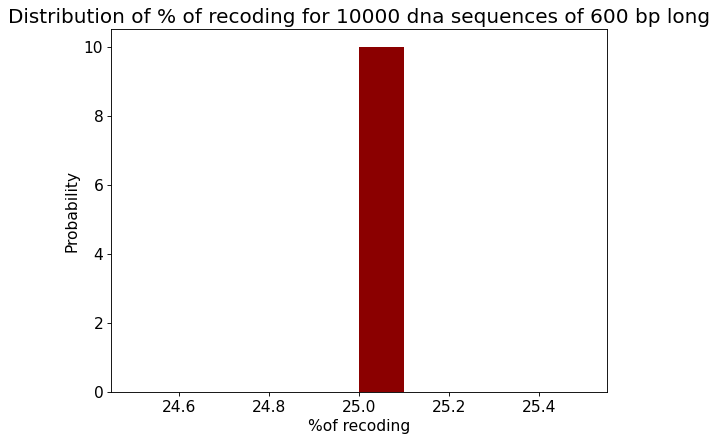

In [97]:
####################################################################################################################
#SECTION CONFIRMATIONS:
####################################################################################################################
def check_if_same_prot(seq1, seq2):
    #check if two cds parts are in frame.
    #print(seq1)
    #print(Seq.Seq(seq1).translate(table=11))
    #print(seq2)
    #print(Seq.Seq(seq2).translate(table=11))
    return  Seq.Seq(seq1).translate(table=11) == Seq.Seq(seq2).translate(table=11)

#see if both part of cds encode for the same protein (recoded vs wt):
same_prot = []
for dic in recoded_in_frame_cdsparts:
    pos = dic["pos"] 
    recoded_part = dic["dna_recoded"]
    start = recoded_dna_seq.find(recoded_part)
    end = start+len(recoded_part)
    print("Est-ce que les positions entre la version wt et wtz sont pareilles : ",(start,end) == pos)
    print("Est-ce que les sequences en adn sont pareilles?: ", recoded_part==dna_seq[start:end])
    same_prot.append(check_if_same_prot(recoded_part,dna_seq[start:end]))

print("Est-ce que toutes les parties de cds encodent pour la meme prot: "+str(all(same_prot)))

#print some graphs, just to be sure of our recoding approach:

def test_recoding_function(nb,len_of_cds,perc):
    cds_test = "AAA" * len_of_cds
    x = [((recode_perc_change(perc,cds_test,rev_ecoli_codon_usage,i)[1])/len_of_cds)*100 for i in range(nb)]
    figure(figsize=(8, 6), dpi=80)    
    plt.title(f"Distribution of % of recoding for {nb} dna sequences of {len_of_cds*3} bp long", fontsize=18)
    plt.hist(x, density=True, color="darkred")  # density=False would make counts
    plt.ylabel('Probability', fontsize=14)
    plt.xlabel('%of recoding', fontsize=14)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.show()
    
test_recoding_function(10000,200,25)

In [56]:
def generate_features_colors(colors_set, pastel_factor,nb_of_features):
#colors_set: the set of colors selected (any integers)
#pastel_factor: the smoothness of colors (between 0-1, 0: no smoothness, 1: a lot of smoothness (near shades of greys))
#nb_of_features: different features from a .tsv file
#https://gist.github.com/adewes/5884820. This portion of the code have been taken from this website.
    def get_random_color(pastel_factor):
        return [(x+pastel_factor)/(1.0+pastel_factor) for x in [random.uniform(0,1.0) for i in [1,2,3]]]

    def color_distance(c1,c2):
        return sum([abs(x[0]-x[1]) for x in zip(c1,c2)])

    def generate_new_color(existing_colors,pastel_factor):
        max_distance = None
        best_color = None
        for i in range(0,100):
            color = get_random_color(pastel_factor = pastel_factor)
            if not existing_colors:
                return color
            best_distance = min([color_distance(color,c) for c in existing_colors])
            if not max_distance or best_distance > max_distance:
                max_distance = best_distance
                best_color = color
        return best_color

    #To make your color choice reproducible, uncomment the following line:
    random.seed(colors_set)

    colors = []
    for i in range(0,nb_of_features):
        colors.append(generate_new_color(colors,pastel_factor = pastel_factor))
    colors_hexa = []
    for color in colors:
        list_of_rgb255 = tuple([round(rgb*255) for rgb in color])
        colors_hexa.append('#%02x%02x%02x' % list_of_rgb255) #convert rgb 255 color format to hexadecimal (needed in the gff3 format). Add the color in the list of colors
    return colors_hexa

#get infos with the initial fasta file and generate annotations:

ajusted1_pos  = [{"start":dics["pos"][0]+1, "end":dics["pos"][1], "annotations":dics["annotations"]} for dics in recoded_in_frame_cdsparts]
corrected_pos = []
rec_perc_annotation = []
overlap_coor = []
for dics in ajusted1_pos:
    start = dics["start"]
    end = dics["end"]
    annotations = dics["annotations"]
    if start == 1:
        new_start = [(dic["start"],dic["end"],dic["annotations"]) for dic in ajusted1_pos if dic["end"] == len_dna_seq] #should only be one value! (should work everytime)
        if new_start:
            start = new_start[0][0]
            corrected_pos.append((start, end))
            rec_perc_annotation.append((dic["annotations"]+annotations)/2)     
    else:
        if start == new_start[0] and end == new_start[1] and annotations == new_start[2]:
            continue
        if end == len_dna_seq:
            continue
        corrected_pos.append((start, end))
        rec_perc_annotation.append(annotations)

if len(corrected_pos) != len(rec_perc_annotation):
    print("THERE IS A PROBLEM WITH ANNOTATIONS, PLEASE REVISE YOUR CODE")

nw_ann = [[f"recoded@{rec_perc_annotation[i]}",str(pos[0]),str(pos[1]),str(pos[1]-pos[0]),"+","misc_feature"] for i,pos in enumerate(corrected_pos)]
df_nw_ann = pd.DataFrame(nw_ann, columns=["Features_name",'start','end','length', 'strand','feat_type'])
#print(df_nw_ann)
#next step, get features from the .tsv file
df = pd.read_csv('../ref_files_m13/Features_from_m13mp18-Kan_annotated_nonatg.txt', delimiter = "\t", header=None)
df.columns = ["Features_name","start..end","length","strand","feat_type"]
df[['start', 'end']] = df['start..end'].str.split('.',1,expand=True)
df['end'] = df['end'].str.replace('.',"")
df["start"] = pd.to_numeric(df["start"], errors='coerce')
df["end"] = pd.to_numeric(df["end"], errors='coerce')
df['strand'] = df['strand'].str.replace('=>',"+")
df['strand'] = df['strand'].str.replace('<=',"-")
df['strand'] = df['strand'].str.replace('==',".")
del df['start..end']
df = df.append(df_nw_ann, ignore_index=True)

#fix the number of disctinct features in dataframe:
distinct_features_type = []
distinct_misc_features_type = []
for index, row in df.iterrows():
    if row["feat_type"] not in distinct_features_type and row["feat_type"] != "misc_feature":
        distinct_features_type.append(row["feat_type"])
    if row["feat_type"] == "misc_feature":
        for genomic_element in ["prom", "rbs","term","rec","non_atg"]: #cette liste doit etre demandee a l'utilisateur
            if genomic_element in row["Features_name"]:
                if genomic_element not in distinct_misc_features_type:
                    distinct_misc_features_type.append(genomic_element)
total_features = distinct_features_type+distinct_misc_features_type
colors = generate_features_colors(10,0,len(total_features))
feat_color = {feature:color for feature,color in zip(total_features,colors)}
colors_indf = []
for index, row in df.iterrows():
    if row["feat_type"] != "misc_feature":
        colors_indf.append(feat_color[row["feat_type"]])
    else:
        for genomic_element in ["prom", "rbs","term","rec","non_atg"]: #cette liste doit etre demandee a l'utilisateur
            if genomic_element in row["Features_name"]:
                colors_indf.append(feat_color[genomic_element])
#get mean_perc
mean_perc = round(statistics.mean([i for i in rec_perc_annotation]),3)
df['colors'] = colors_indf
gff3 = df.copy()
gff3["ID"] = f"m13_rec{mean_perc}"
gff3["source"] = "LaboRodrigue_JFL"
gff3["start"] = gff3["start"]
gff3["annotation"] = 'ID='+gff3['feat_type']+';Name='+gff3['Features_name']+';InRegion;color='+gff3['colors']
gff3["chromosome"] = "L1"
gff3["gene"] = "gene"
gff3["point"] = "."

gff3 = gff3[['ID', 'source', 'feat_type', 'start', 'end', 'point', 'strand', 'point', 'annotation']]
gff3 = gff3.drop_duplicates(subset=['start',"end"], keep="last")

gff3.to_csv('../ref_files_m13/trial_Features_from_m13mp18-Kan_annotated.gff3', sep= "\t")
                    
with open(str('../ref_files_m13/trial_Features_from_m13mp18-Kan_annotated.gff3'), 'w') as f_in:
    f_in.write('##gff-version 3'+'\n')
    f_in.write(gff3.to_csv(header = False, index = False, sep = '\t'))

In [28]:
#Stats on recoded genome:
#is recoded and wt m13 have the same length?
print(f"length of recoded m13 genome : {len(recoded_dna_seq)} and wt m13 genome : {len(dna_seq)}")

#How many punctual mutations in all the recoded genome compared to wt:
count = sum(1 for a, b in zip(dna_seq, recoded_dna_seq) if a != b)
print(f"Number of punctual synonymous mutations in all m13 genome: {count}. {total_changed_codons} codons are changed in all cds of the recoded m13 genome. {(count/6407)*100}% of the m13's genome is modified")

length of recoded m13 genome : 7282 and wt m13 genome : 7282
Number of punctual synonymous mutations in all m13 genome: 505. 429 codons are changed in all cds of the recoded m13 genome. 7.882004058061495% of the m13's genome is modified


In [73]:
#draft of may things!
        
        #append something
        
                
            # else:
            #     new_coors = {}
            #     wrong_frame = True
            #     wrong_frame_lastpos = next_coors[1]
            #     if next_coors[1] < positions[1]: #in the case the next cds (next_coors) is not in frame and shorter than the cds it is compared with:
            #         #appending the part before next_coors[0]:
            #         if not cds_smaller:
            #             parts_to_recode.append({str(dna_seq[positions[0]:next_coors[0]]):(positions[0],next_coors[0])})
            #             last_start = next_coors[0]
            #             last_end = next_coors[1]
            #             cds_smaller = True
            #             try:
            #                 next_coors = all_locations[all_locations.index(next_coors[0],next_coors[1])+1]
            #             except: #if we are at the end of the list, need to append the recoded parts not overlaping with the little cds:                                                                        
            #                 #appending the last part of the recodable cds, excluding the cds not in frame:
            #                 new_coors[dna_seq[next_coors[1]:positions[1]]] = (next_coors[1],positions[1])
            #                 parts_to_recode.append({str(dna_seq[next_coors[1]:positions[1]]):(next_coors[1],positions[1])})
            #         else: #if multiple smaller CDSs
            #             parts_to_recode.append({str(dna_seq[last_start:next_coors[0]]):(positions[0],next_coors[0])})
            #             last_start = next_coors[0]
            #             try:
            #                 next_coors = all_locations[all_locations.index(next_coors[0],next_coors[1])+1]
            #             except: #if we are at the end of the list, need to append the recoded parts not overlaping with the little cds:                                                                        
            #                 #appending the last part of the recodable cds, excluding the cds not in frame:
            #                 new_coors[dna_seq[next_coors[1]:positions[1]]] = (next_coors[1],positions[1])
            #             break
            overlap_coor = #     else:
            #         in_frame_startpos = last_end+((3-last_end-positions[0])%3)
            #         in_frame_end_pos = ###ACHANGER POUR LE IN FRAME ET REMPLACER LE NEXT_COORD[0] PLUS BAS!
            #         if cds_smaller and in_frame_startpos =< next_coors[0]+3: #these two might overlap! Get at least 1 codon !
            #             in_frame_pos = (3-last_end-positions[0])%3
            #             parts_to_recode.append({str(dna_seq[in_frame_pos:next_coors[0]]):(positions[0],next_coors[0])})
            #         break
            # try:
            #     next_coors = all_locations[all_locations.index(next_coors[0],next_coors[1])+1]
            # except: #if we are at the end of the list
            #     break
                
    # elif wrong_frame: #do not append in dict if overlaping region not in frame
    #     if cds_smaller:
    #         parts_to_recode.append({str(dna_seq[next_coors[1]:positions[1]]):(next_coors[1],positions[1])})
    #     continue
    # elif new_coors:
    #     parts_to_recode.append(new_coors)
    # elif not new_coors:
    #     parts_to_recode.append({str(dna_seq[positions[0]:positions[1]]):(positions[0],positions[1])})
    # print(parts_to_recode)
    
# CDSs_no_overlaps = {}
# whose_overlaps = {}   #gene key overlaps with gene value.
# for i, (gene_name, coors) in enumerate(CDSs.items()):
#     CDSs_no_overlaps[gene_name] = {}
#     if i+1 < len(CDSs):
#         next_coors = list(CDSs.values())[i+1]
#         new_coors = {}
#         while next_coors[0] <= coors[1] and coors[0] <= next_coors[1] : # if overlap between 2 cdss
#             whose_overlaps[list(CDSs.keys())[i+1]] = gene_name
#             if gene_name in whose_overlaps: #meaning gene key starts not at the begining of itself, rather after the known end of previously fixed overlapé
#                 max_start_of_gene = max([CDSs[gene][1] for gene in whose_overlaps if gene == gene_name])
#             else:
#                 max_start_of_gene = coors[0]
#             if same_ORF(coors[1],next_coors[0]): #if overlaping cds are in frame, it is possible to recode
#                 new_coors[str(dna_seq[max_start_of_gene:next_coors[0]])] = (max_start_of_gene,coors[1])
#             else: #if there is just one cds not in frame, even if there is other overlaping cds, we cannot recode this part
#                 new_coors[str(dna_seq[max_start_of_gene:next_coors[0]])] = (max_start_of_gene,next_coors[0])
#                 break
#             next_coors = list(CDSs.values())[list(CDSs.values()).index((next_coors[0],next_coors[1]))+1]
#             print(next_coors,gene_name)
#         if not new_coors:
#             CDSs_no_overlaps[gene_name] = {str(dna_seq[coors[0]:coors[1]]):(coors[0],coors[1])}
            
# print(CDSs_no_overlaps)

            
            



# cds_part_no_prob_overlap = overlap_situation(cds_parts,CDSs)
# print(cds_part_no_prob_overlap)
# #print("j suis quoi???",cds_part_no_prob_overlap)

# recoded_genome_parts = {}
# for gene_name, parts in cds_part_no_prob_overlap.items():
#     recoded_genome_parts[gene_name] = {}
#     for part,coor in parts.items():
#         #Search for orf coordinates and recoded the cds:
#         start_part = coor[0]
#         end_part = coor[1]
#         start_codon = start_part+(start_part%3)
#         end_codon = end_part-(end_part%3)
#         if start_part < end_part:
#             in_frame_part = dna_seq[start_codon:end_codon]
#             recoded_part = str(recode_perc_change(50,in_frame_part,rev_ecoli_codon_usage))
#             if recoded_part != "":
#                 recoded_genome_parts[gene_name][recoded_part] = (start_codon,end_codon)
#         else:
#             print("minou")
#             in_frame_part_end = dna_seq[start_codon:max_len_dna]
#             in_frame_part_start = dna_seq[0:end_codon]
#             recoded_part_end = str(recode_perc_change(50,in_frame_part_end,rev_ecoli_codon_usage))
#             recoded_part_start = str(recode_perc_change(50,in_frame_part_start,rev_ecoli_codon_usage))
#             if recoded_part != "":
#                 recoded_genome_parts[gene_name][in_frame_part_end] = (start_codon,max_len_dna)
#                 recoded_genome_parts[gene_name][recoded_part_start] = (0,end_codon)       
# print(recoded_genome_parts)


#construct the final m13 vector:
# all_recoded_start_coor = [str(list(recoded_parts.values())).split(",")[0][2:] for recoded_parts in recoded_genome_parts.values()]
# all_recoded_start_coor = [(recoded_parts.values()) for recoded_parts in recoded_genome_parts.values()]
# print(all_recoded_start_coor)
# all_recoded_end_coor = [coor[1] for seq,coor in parts.items() for recoded_parts in recoded_genome_parts.values()]
# flat_recoded_cds = {coor:seq for seq,coor in partsATGA.items() for parts in recoded_genome_parts.values()}
# print(flat_recoded_cds)

# max_len_dna = len(str(dna_seq))[1,2,3,4,5,6,7,8].index(2)+1
# m13_WTZ = ""
# last_pos = 0
# for i in range(max_len_dna):
#     if i in all_recoded_start_coor:
#         m13_WTZ += dna_seq[last_pos:i]
#         last_pos = i
#     elif i in all_recoded_end_coor:
#         m13_WTZ += dna_seq[last_pos:i]
#         last_pos = i
#     else:
#         continue
# print(len(m13_WTZ))
        
        
#     print("old",cds_parts, "\n")    
#     #le gene en chevauche-t-il un autre? Si oui, couper la partie correspondante dans la liste de gene
#     cds_parts = overlap_situation(coor,cds_parts) 
#     print("new",cds_parts,"\n")
#     print(old_cds_parts==cds_parts)    
#     cds_recoded = {}
#     traceback = []
        
                 
        
        
        #when forbiden_regions[0] < coor[0]
    #find the reading frame in each part of changeable CDSs
    
    #change the reading frame in cds
    
    #merge all substring into a new file

In [71]:
# new_cds = ""
# for pos in range(int(len(cds)/3)):    #25% de chance de le changer
#     codon_in_cds = cds[pos*3:pos*3+3].upper()
#     #set seed at each position in the CDS
#     #random.seed(pos+pos_modifier)
#     if codon_in_cds != "ATG" and codon_in_cds != "TGG":   #if we exclude those codon, because they have no synonymous.
#         if pick_this_pos(perc): #and codon_in_cds != "ATG" and codon_in_cds != "TGG" and pos*3+3 != len(cds): ##########################!!!!!!!!!!!!!!!!!!!
#             #if no TGG (cannot be changed), no start codon (cannot be changed)
#             number_of_changed_codon += 1
#             other_codons = {}
#             for aa, codon_freq in codon_table.items():
#                 if codon_in_cds in codon_freq:
#                     #select the dict for the codon to recode, and evaluate the freq of synonymous codon without codon_in_cds.
#                     for codon,freq in codon_freq.items():
#                         if codon_in_cds != codon:
#                             other_codons[codon] = freq
#             #no need to ponderate frequency now that the codon_in_cds is removed because relative weights are ponderate by default with cumulative wieght (sum of weights)
#             #https://docs.python.org/dev/library/random.html#random.choices
#             #https://stackoverflow.com/questions/55440986/cumulative-weights-in-random-choices
#             replacement_codon = random.choices(population=list(other_codons.keys()),weights=list(other_codons.values()),k=1)
#             new_cds += ''.join(replacement_codon).upper()
#         else:
#             new_cds += codon_in_cds
#     else:
#         new_cds += codon_in_cds
# #new_cds is recoded
# return new_cds,number_of_changed_codon

#recode_perc_change(perc,cds_test,rev_ecoli_codon_usage,1)




#test the recoding function:
#BE SURE TO TEST THE FUNCTION WITHOUT THE VALUE OF SEED FIXED


86
nb codon total 7
{2: 'GCA', 5: 'ACG', 1: 'CGT', 6: 'GTT', 4: 'TCA', 3: 'TCT'}
6
6
True
